In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
import os
import shutil
import torch
import time
import matplotlib.pyplot as plt
%matplotlib inline
from torch import Tensor
from torch.nn import functional as F
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.transforms as tt
from torchvision import models
from torch.utils.data import DataLoader, ConcatDataset, Subset
from tempfile import TemporaryDirectory
from tqdm.notebook import tqdm
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score, balanced_accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from torchsummary import summary

In [ ]:
# https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        # torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def all_scores(labels, preds):
    report = classification_report(labels, preds, digits=3, output_dict=True, zero_division=0)
    acc_sc = balanced_accuracy_score(labels, preds)
    f1_sc = report['macro avg']['f1-score']
    recall_sc = report['macro avg']['recall']
    precision_sc = report['macro avg']['precision']
    return acc_sc, f1_sc, recall_sc, precision_sc

def softmax(x):
    return np.exp(x)/sum(np.exp(x))

def auc_roc_sc(labels, probs):
    pred_soft = [softmax(x) for x in probs]
    return roc_auc_score(labels, pred_soft, average='macro', multi_class='ovr')

In [ ]:
! unzip -q '/content/drive/MyDrive/msc_thesis/data/fer_ckplus.zip'
! unzip -q '/content/drive/MyDrive/msc_thesis/data/kdef.zip'
! unzip -q '/content/drive/MyDrive/msc_thesis/data/rafdb_test.zip'
! unzip -q '/content/drive/MyDrive/msc_thesis/data/rafdb_train.zip'

In [ ]:
valid_size = 490

data_transforms = {
    'train': tt.Compose([tt.Resize((64,64)),
                        tt.Grayscale(num_output_channels=1),
                        tt.RandomHorizontalFlip(),
                        tt.RandomRotation(30),
                        tt.ToTensor()]),
    'val': tt.Compose([tt.Resize((64,64)),
                        tt.Grayscale(num_output_channels=1),
                        tt.ToTensor()]),
}

train_data = ImageFolder('/content/fer_ckplus', data_transforms['train'])
val_data = ImageFolder('/content/fer_ckplus', data_transforms['val'])

train_indices, val_indices, _, _ = train_test_split(
    range(len(train_data)),
    train_data.targets,
    stratify=train_data.targets,
    test_size=valid_size,
)

train_split = Subset(train_data, train_indices)
val_split = Subset(val_data, val_indices)
image_datasets = {
    'train': train_split,
    'val': val_split
    }

batch_size = 64
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size,
                                            shuffle=True, num_workers=2)
            for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# source for training funtion https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#training-the-model
def train_model(model, criterion, optimizer, scheduler, grad_clip, num_epochs=20, patience=10):
    since = time.time()
    results = {'acc': [], 'f1': [], 'rec': [], 'prec': [], 'roc': []}

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        early_stopping = EarlyStopping(patience=patience, verbose=False)
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode
                    pred_list = []
                    label_list = []
                    output_list = []

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in tqdm(dataloaders[phase], leave=False, desc=phase):
                    if phase == 'val':
                        label_list = label_list + labels.tolist()

                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'val':
                            output_list = output_list + outputs.tolist()
                            pred_list = pred_list + preds.tolist()

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            if grad_clip:
                                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                            optimizer.step()
                            scheduler.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    train_loss = running_loss / dataset_sizes[phase]
                if phase == 'val':
                    val_loss = running_loss / dataset_sizes[phase]
                    acc, f1, prec, rec = all_scores(label_list, pred_list)
                    roc = auc_roc_sc(label_list, output_list)

                    results['acc'].append(acc)
                    results['f1'].append(f1)
                    results['prec'].append(prec)
                    results['rec'].append(rec)
                    results['roc'].append(roc)

                    if epoch < 10:
                        s = '0'
                    else:
                        s = ''

                    print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
                        s+str(epoch), get_lr(optimizer), train_loss, val_loss, acc))

                # print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and acc > best_acc:
                    best_acc = acc
                    torch.save(model.state_dict(), best_model_params_path)

                    early_stopping(val_loss, model)

                    if early_stopping.early_stop:
                        print("Early stopping")
                        break

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model, results

In [ ]:
from torchvision.ops.misc import Conv2dNormActivation, Permute
import torch.nn.init as init
from typing import Any, Callable, Dict, List, Optional, Sequence, Tuple, Union
import copy
import math
from torchvision.models.squeezenet import Fire
from functools import partial

In [ ]:
# https://pytorch.org/vision/stable/_modules/torchvision/models/squeezenet.html
class SqueezeNet(nn.Module):
    def __init__(self, version: str = "1_1", num_classes: int = 7, dropout: float = 0.5) -> None:
        super().__init__()
        # _log_api_usage_once(self)
        self.num_classes = num_classes
        if version == "1_0":
            self.features = nn.Sequential(
                nn.Conv2d(1, 96, kernel_size=7, stride=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(96, 16, 64, 64),
                Fire(128, 16, 64, 64),
                Fire(128, 32, 128, 128),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 32, 128, 128),
                Fire(256, 48, 192, 192),
                Fire(384, 48, 192, 192),
                Fire(384, 64, 256, 256),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(512, 64, 256, 256),
            )
        elif version == "1_1":
            self.features = nn.Sequential(
                nn.Conv2d(1, 64, kernel_size=3, stride=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(64, 16, 64, 64),
                Fire(128, 16, 64, 64),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(128, 32, 128, 128),
                Fire(256, 32, 128, 128),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 48, 192, 192),
                Fire(384, 48, 192, 192),
                Fire(384, 64, 256, 256),
                Fire(512, 64, 256, 256),
            )
        else:
            # FIXME: Is this needed? SqueezeNet should only be called from the
            # FIXME: squeezenet1_x() functions
            # FIXME: This checking is not done for the other models
            raise ValueError(f"Unsupported SqueezeNet version {version}: 1_0 or 1_1 expected")

        # Final convolution is initialized differently from the rest
        final_conv = nn.Conv2d(512, self.num_classes, kernel_size=1)
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout), final_conv, nn.ReLU(inplace=True), nn.AdaptiveAvgPool2d((1, 1))
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if m is final_conv:
                    init.normal_(m.weight, mean=0.0, std=0.01)
                else:
                    init.kaiming_uniform_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.classifier(x)
        return torch.flatten(x, 1)

In [ ]:
model = SqueezeNet()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
max_lr = 0.001
epochs = 90
grad_clip = 0.1
weight_decay = 1e-4
optimizer = torch.optim.Adam(model.parameters(), max_lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(dataloaders['train']))

In [ ]:
summary(model, (1,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 31, 31]             640
              ReLU-2           [-1, 64, 31, 31]               0
         MaxPool2d-3           [-1, 64, 15, 15]               0
            Conv2d-4           [-1, 16, 15, 15]           1,040
              ReLU-5           [-1, 16, 15, 15]               0
            Conv2d-6           [-1, 64, 15, 15]           1,088
              ReLU-7           [-1, 64, 15, 15]               0
            Conv2d-8           [-1, 64, 15, 15]           9,280
              ReLU-9           [-1, 64, 15, 15]               0
             Fire-10          [-1, 128, 15, 15]               0
           Conv2d-11           [-1, 16, 15, 15]           2,064
             ReLU-12           [-1, 16, 15, 15]               0
           Conv2d-13           [-1, 64, 15, 15]           1,088
             ReLU-14           [-1, 64,

In [ ]:
model, results =  train_model(model, criterion, optimizer, scheduler, grad_clip, num_epochs=epochs, patience=4)

train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [00], last_lr: 0.00004, train_loss: 1.8395, val_loss: 1.8194, val_acc: 0.1429


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [01], last_lr: 0.00005, train_loss: 1.8161, val_loss: 1.7959, val_acc: 0.1429


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [02], last_lr: 0.00007, train_loss: 1.7761, val_loss: 1.6786, val_acc: 0.2304


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [03], last_lr: 0.00009, train_loss: 1.6706, val_loss: 1.6035, val_acc: 0.2723


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [04], last_lr: 0.00012, train_loss: 1.5897, val_loss: 1.5366, val_acc: 0.2711


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [05], last_lr: 0.00015, train_loss: 1.5454, val_loss: 1.4782, val_acc: 0.3242


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [06], last_lr: 0.00019, train_loss: 1.5055, val_loss: 1.4460, val_acc: 0.3281


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [07], last_lr: 0.00023, train_loss: 1.4708, val_loss: 1.4124, val_acc: 0.3516


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [08], last_lr: 0.00028, train_loss: 1.4405, val_loss: 1.3897, val_acc: 0.3864


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [09], last_lr: 0.00033, train_loss: 1.4087, val_loss: 1.3571, val_acc: 0.3757


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [10], last_lr: 0.00038, train_loss: 1.3835, val_loss: 1.2941, val_acc: 0.3817


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [11], last_lr: 0.00044, train_loss: 1.3504, val_loss: 1.3287, val_acc: 0.3607


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [12], last_lr: 0.00049, train_loss: 1.3344, val_loss: 1.2609, val_acc: 0.3917


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [13], last_lr: 0.00055, train_loss: 1.3157, val_loss: 1.2556, val_acc: 0.4097


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [14], last_lr: 0.00060, train_loss: 1.2910, val_loss: 1.3110, val_acc: 0.3826


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [15], last_lr: 0.00066, train_loss: 1.2712, val_loss: 1.2031, val_acc: 0.4372


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [16], last_lr: 0.00071, train_loss: 1.2567, val_loss: 1.1813, val_acc: 0.4328


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [17], last_lr: 0.00076, train_loss: 1.2428, val_loss: 1.1771, val_acc: 0.4411


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [18], last_lr: 0.00081, train_loss: 1.2297, val_loss: 1.1865, val_acc: 0.4222


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [19], last_lr: 0.00085, train_loss: 1.2165, val_loss: 1.1897, val_acc: 0.4580
EarlyStopping counter: 1 out of 4


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [20], last_lr: 0.00089, train_loss: 1.2068, val_loss: 1.1513, val_acc: 0.4479


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [21], last_lr: 0.00092, train_loss: 1.1995, val_loss: 1.1408, val_acc: 0.4522


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [22], last_lr: 0.00095, train_loss: 1.1876, val_loss: 1.1391, val_acc: 0.4750


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [23], last_lr: 0.00097, train_loss: 1.1702, val_loss: 1.1020, val_acc: 0.4941


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [24], last_lr: 0.00099, train_loss: 1.1605, val_loss: 1.1485, val_acc: 0.4524


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [25], last_lr: 0.00100, train_loss: 1.1518, val_loss: 1.0588, val_acc: 0.4876


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [26], last_lr: 0.00100, train_loss: 1.1372, val_loss: 1.1007, val_acc: 0.4798


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [27], last_lr: 0.00100, train_loss: 1.1243, val_loss: 1.1126, val_acc: 0.4497


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [28], last_lr: 0.00100, train_loss: 1.1203, val_loss: 1.0580, val_acc: 0.4978


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [29], last_lr: 0.00099, train_loss: 1.1007, val_loss: 1.0340, val_acc: 0.5190


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [30], last_lr: 0.00099, train_loss: 1.0790, val_loss: 1.0273, val_acc: 0.5428


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [31], last_lr: 0.00098, train_loss: 1.0662, val_loss: 0.9938, val_acc: 0.5858


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [32], last_lr: 0.00098, train_loss: 1.0551, val_loss: 1.0371, val_acc: 0.5209


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [33], last_lr: 0.00097, train_loss: 1.0493, val_loss: 0.9859, val_acc: 0.5226


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [34], last_lr: 0.00096, train_loss: 1.0373, val_loss: 1.0143, val_acc: 0.5617


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [35], last_lr: 0.00095, train_loss: 1.0186, val_loss: 0.9404, val_acc: 0.5811


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [36], last_lr: 0.00094, train_loss: 1.0191, val_loss: 0.9934, val_acc: 0.5931


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [37], last_lr: 0.00093, train_loss: 1.0067, val_loss: 0.9902, val_acc: 0.5864


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [38], last_lr: 0.00091, train_loss: 0.9996, val_loss: 0.9082, val_acc: 0.6055


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [39], last_lr: 0.00090, train_loss: 0.9926, val_loss: 0.9907, val_acc: 0.5643


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [40], last_lr: 0.00088, train_loss: 0.9851, val_loss: 0.9689, val_acc: 0.5511


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [41], last_lr: 0.00087, train_loss: 0.9766, val_loss: 0.8870, val_acc: 0.6496


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [42], last_lr: 0.00085, train_loss: 0.9698, val_loss: 0.9613, val_acc: 0.5741


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [43], last_lr: 0.00083, train_loss: 0.9611, val_loss: 0.9128, val_acc: 0.6076


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [44], last_lr: 0.00081, train_loss: 0.9504, val_loss: 0.8879, val_acc: 0.6396


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [45], last_lr: 0.00079, train_loss: 0.9466, val_loss: 0.8911, val_acc: 0.6050


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [46], last_lr: 0.00077, train_loss: 0.9398, val_loss: 0.9530, val_acc: 0.5742


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [47], last_lr: 0.00075, train_loss: 0.9298, val_loss: 0.9419, val_acc: 0.5868


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [48], last_lr: 0.00073, train_loss: 0.9168, val_loss: 0.9415, val_acc: 0.5789


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [49], last_lr: 0.00071, train_loss: 0.9146, val_loss: 0.8593, val_acc: 0.6176


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [50], last_lr: 0.00068, train_loss: 0.9081, val_loss: 0.8667, val_acc: 0.6047


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [51], last_lr: 0.00066, train_loss: 0.8935, val_loss: 0.8972, val_acc: 0.6456


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [52], last_lr: 0.00064, train_loss: 0.8854, val_loss: 0.8715, val_acc: 0.6115


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [53], last_lr: 0.00061, train_loss: 0.8826, val_loss: 0.8978, val_acc: 0.5988


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [54], last_lr: 0.00059, train_loss: 0.8754, val_loss: 0.8679, val_acc: 0.6235


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [55], last_lr: 0.00056, train_loss: 0.8632, val_loss: 0.8998, val_acc: 0.6313


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [56], last_lr: 0.00054, train_loss: 0.8575, val_loss: 0.8506, val_acc: 0.6272


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [57], last_lr: 0.00051, train_loss: 0.8464, val_loss: 0.8658, val_acc: 0.6301


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [58], last_lr: 0.00049, train_loss: 0.8381, val_loss: 0.8769, val_acc: 0.6444


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [59], last_lr: 0.00046, train_loss: 0.8256, val_loss: 0.8388, val_acc: 0.6348


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [60], last_lr: 0.00044, train_loss: 0.8212, val_loss: 0.8168, val_acc: 0.6524


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [61], last_lr: 0.00041, train_loss: 0.8155, val_loss: 0.8815, val_acc: 0.6307


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [62], last_lr: 0.00039, train_loss: 0.8073, val_loss: 0.8750, val_acc: 0.6244


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [63], last_lr: 0.00036, train_loss: 0.7967, val_loss: 0.8785, val_acc: 0.6238


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [64], last_lr: 0.00034, train_loss: 0.7880, val_loss: 0.8026, val_acc: 0.6370


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [65], last_lr: 0.00032, train_loss: 0.7876, val_loss: 0.8252, val_acc: 0.6335


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [66], last_lr: 0.00029, train_loss: 0.7750, val_loss: 0.8071, val_acc: 0.6550


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [67], last_lr: 0.00027, train_loss: 0.7663, val_loss: 0.8308, val_acc: 0.6651
EarlyStopping counter: 1 out of 4


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [68], last_lr: 0.00025, train_loss: 0.7568, val_loss: 0.8375, val_acc: 0.6417


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [69], last_lr: 0.00023, train_loss: 0.7489, val_loss: 0.8271, val_acc: 0.6500


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [70], last_lr: 0.00021, train_loss: 0.7417, val_loss: 0.8158, val_acc: 0.6770
EarlyStopping counter: 2 out of 4


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [71], last_lr: 0.00019, train_loss: 0.7372, val_loss: 0.8333, val_acc: 0.6494


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [72], last_lr: 0.00017, train_loss: 0.7287, val_loss: 0.7862, val_acc: 0.6528


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [73], last_lr: 0.00015, train_loss: 0.7199, val_loss: 0.7998, val_acc: 0.6462


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [74], last_lr: 0.00013, train_loss: 0.7165, val_loss: 0.8165, val_acc: 0.6301


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [75], last_lr: 0.00012, train_loss: 0.7064, val_loss: 0.8286, val_acc: 0.6628


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [76], last_lr: 0.00010, train_loss: 0.7026, val_loss: 0.8044, val_acc: 0.6623


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [77], last_lr: 0.00009, train_loss: 0.6981, val_loss: 0.8623, val_acc: 0.6285


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [78], last_lr: 0.00007, train_loss: 0.6891, val_loss: 0.8111, val_acc: 0.6637


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [79], last_lr: 0.00006, train_loss: 0.6875, val_loss: 0.7943, val_acc: 0.6605


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [80], last_lr: 0.00005, train_loss: 0.6833, val_loss: 0.8089, val_acc: 0.6381


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [81], last_lr: 0.00004, train_loss: 0.6807, val_loss: 0.7969, val_acc: 0.6775


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [82], last_lr: 0.00003, train_loss: 0.6745, val_loss: 0.8122, val_acc: 0.6494


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [83], last_lr: 0.00002, train_loss: 0.6690, val_loss: 0.8632, val_acc: 0.6307


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [84], last_lr: 0.00002, train_loss: 0.6710, val_loss: 0.7860, val_acc: 0.6765


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [85], last_lr: 0.00001, train_loss: 0.6687, val_loss: 0.8370, val_acc: 0.6457


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [86], last_lr: 0.00001, train_loss: 0.6665, val_loss: 0.8029, val_acc: 0.6508


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [87], last_lr: 0.00000, train_loss: 0.6670, val_loss: 0.8455, val_acc: 0.6453


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [88], last_lr: 0.00000, train_loss: 0.6623, val_loss: 0.8202, val_acc: 0.6401


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [89], last_lr: 0.00000, train_loss: 0.6644, val_loss: 0.7796, val_acc: 0.6534
Training complete in 61m 39s
Best val Acc: 0.677502


In [ ]:
kdef_ds = ImageFolder('/content/kdef', data_transforms['val'])
kdef_test_dl = DataLoader(kdef_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

model.eval()
label_list = []
output_list = []
pred_list = []
for inputs, labels in tqdm(kdef_test_dl, leave=False, desc='Test'):
    label_list = label_list + labels.tolist()

    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.set_grad_enabled(False):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        output_list = output_list + outputs.tolist()
        pred_list = pred_list + preds.tolist()
acc, f1, prec, rec = all_scores(label_list, pred_list)
roc = auc_roc_sc(label_list, output_list)

print('acc:', round(acc, 4), ', roc:', round(roc, 4), ', f1:', round(f1, 4), ', recall:', round(rec, 4))

Test:   0%|          | 0/8 [00:00<?, ?it/s]

acc: 0.5633 , roc: 0.9037 , f1: 0.5281 , recall: 0.6871


In [ ]:
test_raf_ds = ImageFolder('/content/rafdb_test', data_transforms['val'])
test_raf_dl = DataLoader(test_raf_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

model.eval()
label_list = []
output_list = []
pred_list = []
for inputs, labels in tqdm(test_raf_dl, leave=False, desc='Test'):
    label_list = label_list + labels.tolist()

    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.set_grad_enabled(False):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        output_list = output_list + outputs.tolist()
        pred_list = pred_list + preds.tolist()
acc, f1, prec, rec = all_scores(label_list, pred_list)
roc = auc_roc_sc(label_list, output_list)

print('acc:', round(acc, 4), ', roc:', round(roc, 4), ', f1:', round(f1, 4), ', recall:', round(rec, 4))

Test:   0%|          | 0/48 [00:00<?, ?it/s]

acc: 0.457 , roc: 0.8546 , f1: 0.432 , recall: 0.5129


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/msc_thesis/notebooks/squeezenet.pt')

In [ ]:
print(results)

{'acc': [0.14285714285714285, 0.14285714285714285, 0.23036272450029932, 0.27229522731520506, 0.2711485584544143, 0.3242228008763578, 0.32809664026024815, 0.3516011546833557, 0.3863819326611636, 0.37567381619056167, 0.3817083922005141, 0.3606692059633424, 0.3916901187406209, 0.409674798423477, 0.38264190138046933, 0.4371705290106783, 0.4327995017431251, 0.44113879444655774, 0.4222423786148931, 0.4580415002786486, 0.44788569137481005, 0.4522444705166763, 0.4749566614155199, 0.49410243801629966, 0.45244425605926525, 0.4876261107493007, 0.4798359940086096, 0.44965122774500493, 0.4978435740182631, 0.5190045988641657, 0.542794773415949, 0.585752225055829, 0.5209332795793573, 0.5226098696382369, 0.5616606435868728, 0.5811179296691362, 0.5930855611100004, 0.5863754245737519, 0.6055316487864243, 0.5643277263624606, 0.5511295211706176, 0.6496303038973562, 0.5740622449158602, 0.6076153874483288, 0.6396439385624108, 0.6049591982352905, 0.5742303777271435, 0.586776664603046, 0.5789028448986071, 0.6

In [ ]:
results = {'acc': [0.14285714285714285, 0.14285714285714285, 0.23036272450029932, 0.27229522731520506, 0.2711485584544143, 0.3242228008763578, 0.32809664026024815, 0.3516011546833557, 0.3863819326611636, 0.37567381619056167, 0.3817083922005141, 0.3606692059633424, 0.3916901187406209, 0.409674798423477, 0.38264190138046933, 0.4371705290106783, 0.4327995017431251, 0.44113879444655774, 0.4222423786148931, 0.4580415002786486, 0.44788569137481005, 0.4522444705166763, 0.4749566614155199, 0.49410243801629966, 0.45244425605926525, 0.4876261107493007, 0.4798359940086096, 0.44965122774500493, 0.4978435740182631, 0.5190045988641657, 0.542794773415949, 0.585752225055829, 0.5209332795793573, 0.5226098696382369, 0.5616606435868728, 0.5811179296691362, 0.5930855611100004, 0.5863754245737519, 0.6055316487864243, 0.5643277263624606, 0.5511295211706176, 0.6496303038973562, 0.5740622449158602, 0.6076153874483288, 0.6396439385624108, 0.6049591982352905, 0.5742303777271435, 0.586776664603046, 0.5789028448986071, 0.6176323840502399, 0.6047223056620101, 0.6455957114162485, 0.6115236382291396, 0.5988005389091159, 0.623505040122971, 0.6313047478082099, 0.6272258341375302, 0.6300945816590641, 0.6443930999335371, 0.6347953284560346, 0.6524096576769889, 0.6307096041658722, 0.6243921385760306, 0.6238409669056372, 0.63700482717342, 0.6335235904313913, 0.6549767753898597, 0.6650925295784099, 0.6417047991474816, 0.6500493186422341, 0.6769814148837787, 0.6494455918139439, 0.6527688652994706, 0.6462196923875988, 0.6300991679073181, 0.662796179303235, 0.6623289244080242, 0.6284543402038282, 0.663724952474163, 0.6605430548352239, 0.6380842304115895, 0.6775019050990306, 0.6494275416876241, 0.630664749050074, 0.6764879851297992, 0.6456769447105722, 0.6508097172996188, 0.6453064261327708, 0.6400723494826382, 0.6533766054430943], 'f1': [0.06242879927090454, 0.06242879927090454, 0.1840260915305362, 0.21465334212194614, 0.216459158455052, 0.2974665341837028, 0.2843559873403993, 0.3054009019909913, 0.33870455444944714, 0.3368270387300966, 0.3571670929904874, 0.30904051834502294, 0.3538382292001481, 0.38315467255515784, 0.349131075510516, 0.40626295934608414, 0.4329702044949186, 0.4102356156364128, 0.4099857746296101, 0.4559990056635412, 0.42588271130566413, 0.4410778511131225, 0.45811839197764215, 0.48750545589235117, 0.4446416305272762, 0.4713737554052279, 0.48514808808625354, 0.4502279798643087, 0.4844950934362299, 0.5172255469348845, 0.5653446105625438, 0.5978819730885, 0.5383201852119465, 0.5486014330192065, 0.5834731840313362, 0.6045307852322114, 0.6082583924571457, 0.6047608815497061, 0.6279467528115902, 0.5695224783298964, 0.564394677652982, 0.6691919135299157, 0.597408840354439, 0.6201865951985164, 0.652647463466959, 0.629639178679767, 0.5924487689228324, 0.6099071915565614, 0.5908716884629813, 0.6409094495944058, 0.6180438506814899, 0.6666873062082639, 0.6191159081929641, 0.6147147246013732, 0.6336120119964088, 0.6534962691383251, 0.6409324268279291, 0.6276385345530394, 0.6650992378043199, 0.6620262229033017, 0.6655530657461179, 0.636680790478847, 0.6424621280500805, 0.6289752312896351, 0.6537835139957345, 0.6356766437177391, 0.6608088024088682, 0.6910329038466548, 0.6571873865004717, 0.6730457170726103, 0.6766377941281575, 0.6430361481207402, 0.6621044393925815, 0.6558803362535816, 0.6491730707709741, 0.6630032866826024, 0.6726115372822402, 0.6504767278480815, 0.6843560711199889, 0.6582833402123869, 0.6484720536680565, 0.6852102071556959, 0.6660845552646794, 0.6436086919233269, 0.6899436116086362, 0.6585080182493879, 0.6690446269153018, 0.654789146557132, 0.6529047222420532, 0.6718473952663199], 'rec': [0.03994169096209913, 0.03994169096209913, 0.22126097119922372, 0.24637963727648057, 0.19109277651104292, 0.29708596716408087, 0.26559753475271813, 0.31711072105350485, 0.3892062993415835, 0.37716818510218425, 0.3719059985257499, 0.3057645878229218, 0.3871917460876272, 0.3894487089204891, 0.380809825492238, 0.4486271276786176, 0.4503128352461525, 0.40827779863840885, 0.47164538425553537, 0.4719706814473117, 0.4528858041173312, 0.46721707242411986, 0.4649591594626083, 0.48527566754575513, 0.4774907849125652, 0.4847919336197256, 0.5216879972241739, 0.5092646742491463, 0.48301267565017064, 0.5311522037054127, 0.6376273737990837, 0.6336713231253838, 0.6820127178982094, 0.6579213689198652, 0.653796985364779, 0.6919808780356448, 0.6418785572512281, 0.6823288121535784, 0.6844762617793385, 0.5993504605486828, 0.6219489440179097, 0.7081013433622557, 0.6822197050324422, 0.6553148145613898, 0.6743897430937279, 0.7092714403991313, 0.6527868610903031, 0.6671131553195594, 0.6143030984918731, 0.7013313505901106, 0.649212946672922, 0.7129824870012204, 0.6393515799917077, 0.6438113356537123, 0.670724696588663, 0.6980406719902871, 0.6686192493948184, 0.632528013873009, 0.710124712455333, 0.725951985279812, 0.6996916563832479, 0.6501516797302997, 0.6805653135923054, 0.6682687629890995, 0.6847072393904162, 0.6574953059215697, 0.6869593847035791, 0.7383392177688262, 0.6920737917793284, 0.7184124246021868, 0.6852669736293413, 0.6483492101193319, 0.6808411995072349, 0.6688437134485766, 0.6808846213859248, 0.6671315185744452, 0.6876096585992019, 0.6969644463045119, 0.7180019828186135, 0.6608300640143611, 0.6684274103794287, 0.699933885116882, 0.6938639610588382, 0.6641782584421209, 0.7091700619059029, 0.6782308224204937, 0.6990272860149993, 0.6747900582079575, 0.6750853677390409, 0.7066855996109837], 'prec': [0.14285714285714285, 0.14285714285714285, 0.23036272450029932, 0.27229522731520506, 0.2711485584544143, 0.3242228008763578, 0.32809664026024815, 0.3516011546833557, 0.3863819326611636, 0.37567381619056167, 0.3817083922005141, 0.3606692059633424, 0.3916901187406209, 0.409674798423477, 0.38264190138046933, 0.4371705290106783, 0.4327995017431251, 0.44113879444655774, 0.4222423786148931, 0.4580415002786486, 0.44788569137481005, 0.4522444705166763, 0.4749566614155199, 0.49410243801629966, 0.45244425605926525, 0.4876261107493007, 0.4798359940086096, 0.44965122774500493, 0.4978435740182631, 0.5190045988641657, 0.542794773415949, 0.585752225055829, 0.5209332795793573, 0.5226098696382369, 0.5616606435868728, 0.5811179296691362, 0.5930855611100004, 0.5863754245737519, 0.6055316487864243, 0.5643277263624606, 0.5511295211706176, 0.6496303038973562, 0.5740622449158602, 0.6076153874483288, 0.6396439385624108, 0.6049591982352905, 0.5742303777271435, 0.586776664603046, 0.5789028448986071, 0.6176323840502399, 0.6047223056620101, 0.6455957114162485, 0.6115236382291396, 0.5988005389091159, 0.623505040122971, 0.6313047478082099, 0.6272258341375302, 0.6300945816590641, 0.6443930999335371, 0.6347953284560346, 0.6524096576769889, 0.6307096041658722, 0.6243921385760306, 0.6238409669056372, 0.63700482717342, 0.6335235904313913, 0.6549767753898597, 0.6650925295784099, 0.6417047991474816, 0.6500493186422341, 0.6769814148837787, 0.6494455918139439, 0.6527688652994706, 0.6462196923875988, 0.6300991679073181, 0.662796179303235, 0.6623289244080242, 0.6284543402038282, 0.663724952474163, 0.6605430548352239, 0.6380842304115895, 0.6775019050990306, 0.6494275416876241, 0.630664749050074, 0.6764879851297992, 0.6456769447105722, 0.6508097172996188, 0.6453064261327708, 0.6400723494826382, 0.6533766054430943], 'roc': [0.49413237059774273, 0.5786894297468449, 0.6342907296254329, 0.6703459134127959, 0.7056142567694336, 0.7293100260957756, 0.7609743677312916, 0.7665947804733173, 0.7992336989648336, 0.8073157270055853, 0.8111384913168168, 0.8234538435791146, 0.83795822311402, 0.8340856250098577, 0.7997146825372672, 0.8574372549762492, 0.8627446508275545, 0.8641337563530979, 0.8520362728598487, 0.8651277121497645, 0.8679082765780599, 0.8783659316291158, 0.8643319592268967, 0.8866582439594085, 0.8766762699554304, 0.8860144882550809, 0.8678100857324373, 0.8802990900695402, 0.8924765221338767, 0.8974740178015682, 0.8933737218498295, 0.8989626152065727, 0.8925879185641998, 0.9000117305370406, 0.900402549925076, 0.912462564409957, 0.9059942518344338, 0.9057067869826136, 0.9169460680842259, 0.9088540203366232, 0.9079145059505735, 0.9198225359570508, 0.9113988666936275, 0.9172954685143803, 0.9242589913715149, 0.9188878690064476, 0.9157431298221786, 0.9113992517407118, 0.9127566435568921, 0.9277760914319464, 0.9271580714817009, 0.9149908820353393, 0.9262539384588884, 0.9202080340977218, 0.9242888217511085, 0.9201125176638563, 0.9280631057145072, 0.9262503572882081, 0.9210450802735483, 0.9279036738941223, 0.931579753250167, 0.9256319904117587, 0.9248818679614967, 0.9258067700753563, 0.9367377500150876, 0.9316828871798511, 0.9348204446660366, 0.9335054631129767, 0.9293446291527446, 0.930797721665836, 0.9321010286171759, 0.9326286534864262, 0.9383632348577053, 0.9309543317302441, 0.934177928839443, 0.9313801699585669, 0.9351437344711374, 0.9205236688045494, 0.9343016511481407, 0.9371237809690232, 0.9313797422994886, 0.9366928009060337, 0.9317039337206616, 0.926645819821366, 0.9354718652441057, 0.9313233224697418, 0.9375209531129748, 0.9309934696193674, 0.9336473147125101, 0.9374734843434486]}


In [ ]:
criterion = nn.CrossEntropyLoss()
model = SqueezeNet()
model.load_state_dict(torch.load('/content/drive/MyDrive/msc_thesis/notebooks/squeezenet.pt'))
model = model.to(device)

In [ ]:
! unzip -q '/content/drive/MyDrive/msc_thesis/data/kdef_faces.zip'
criterion = nn.CrossEntropyLoss()
kdef_f_ds = ImageFolder('/content/kdef_faces', data_transforms['val'])
kdef_f_test_dl = DataLoader(kdef_f_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

model.eval()
label_list = []
output_list = []
pred_list = []
for inputs, labels in tqdm(kdef_f_test_dl, leave=False, desc='Test'):
    label_list = label_list + labels.tolist()

    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.set_grad_enabled(False):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        output_list = output_list + outputs.tolist()
        pred_list = pred_list + preds.tolist()
acc, f1, prec, rec = all_scores(label_list, pred_list)
roc = auc_roc_sc(label_list, output_list)

print('acc:', round(acc, 4), ', roc:', round(roc, 4), ', f1:', round(f1, 4), ', recall:', round(rec, 4))

Test:   0%|          | 0/8 [00:00<?, ?it/s]

acc: 0.702 , roc: 0.9409 , f1: 0.6827 , recall: 0.7423


In [ ]:
def plot_scores(results):
    plt.figure(figsize=(8, 6), dpi=150)
    epochs = len(results['acc'])
    # plt.plot(results['prec'], color='limegreen', label='precision')
    plt.plot(results['rec'], color='orange', label='recall')
    plt.plot(results['f1'], color='dodgerblue', label='f1-score')
    plt.plot(results['roc'], color = 'blueviolet', label='roc-auc')
    plt.plot(results['acc'], color='red', label='accuracy')
    plt.ylabel('performance scores')
    plt.ylim([0,1])
    plt.legend(loc='lower right')
    plt.xlabel('epoch')
    plt.title('Model performance vs. No. of epochs')
    plt.show()

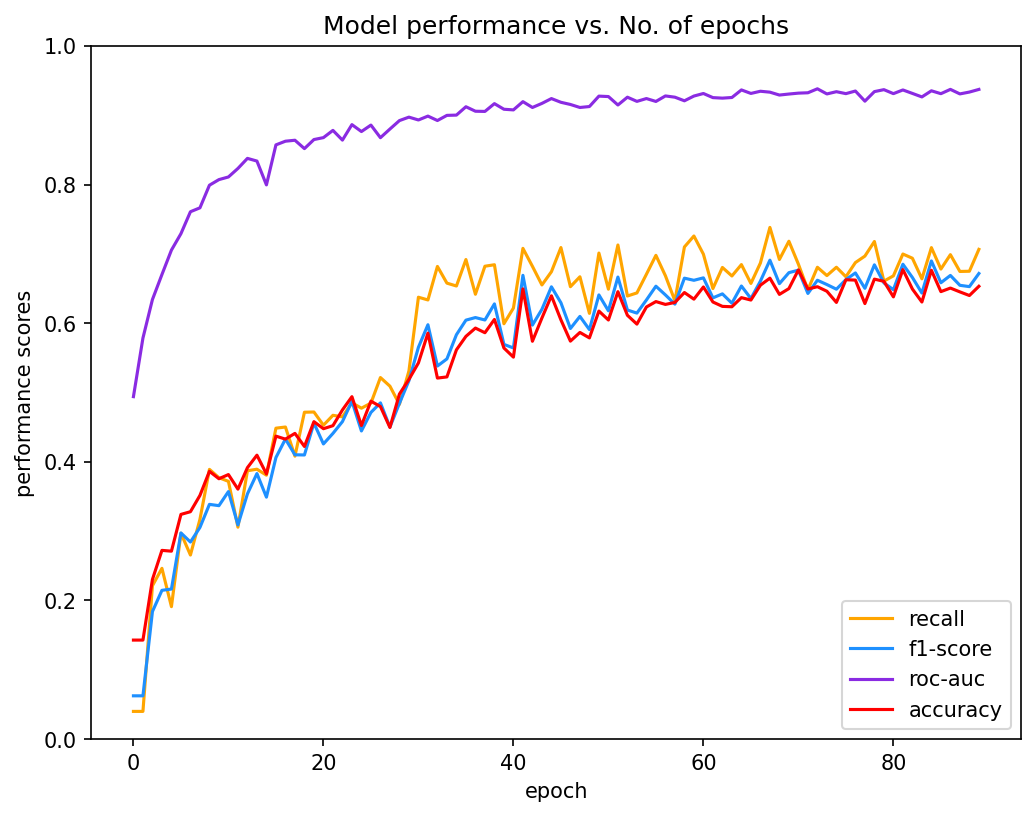

In [ ]:
plot_scores(results)